In [1]:
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import numpy as np
import warnings
import json
warnings.simplefilter(action='ignore')

2020當下篩出的分類

回測2020全年 -> 

In [26]:
'''
# ETF1:國內成分證券 ETF
etf1_list = ["VTI","IWB","SOXX","XLI","XLY","VIOV","XLE","DIA","VOX","XLP","XLK","XLF","QQQ","VOO"]
# ETF2:國外成分證券 ETF(股票)
etf2_list = ['VXUS','ACWX','SCHF','IDV','VEU']
# ETF3:境外 ETF
etf3_list = []
# ETF4:槓桿行 ETF
etf4_list = ['SOXL','TQQQ','UPRO','FAS','SSO']
# ETF5:反向行 ETF
etf5_list = ['PSQ','SOXS','SH','SQQQ','SDS']
# ETF6:原型期貨
etf6_list = ['USO','GLD']
# ETF7:槓桿型期貨 ETF
etf7_list = ['UCO']
# ETF8:反向型期貨 ETF 
etf8_list = ['SCO']
# ETF9:國外成分證券 ETF(證券)
etf9_list = ['IGOV','BNDX','IBND','BGRN','VWOB']
'''
with open("farrell_at2020_top100_cluster9.json", "r") as f:
    data = json.load(f)

etf_list = data

def get_etf_list(etf_list):
    all_etf_list = []
    for etf in etf_list.values():
        all_etf_list.extend(etf)
    return all_etf_list
etfs = get_etf_list(etf_list)


In [4]:

def get_data_from_yfinance(pool: list, start="1980-01-01", end=datetime.now()) -> pd.DataFrame:
    df = yf.download(pool, start=start, end=end, ignore_tz=True, progress=False)
    Adj_rate = df['Adj Close']/df['Close']
    for column in ['Close', 'Open', 'High', 'Low']:
        df[column] *= Adj_rate
        df[column] = df[column].ffill()  # fill forward 
    return df.loc[:, (slice(None), pool)]['Close']  

def count_return(df_etfs,etf_list):
    df_etf = df_etfs[df_etfs.columns.intersection(etf_list)]
    df_etf['equal_weight_sum'] = df_etf.sum(axis=1)
    for etf in df_etf.columns:
        df_etf[str(etf)+'weight'] = df_etf[str(etf)]**2/df_etf['equal_weight_sum']
    df_etf['value_weight_sum'] =df_etf.iloc[:,(len(etf_list)+1):].sum(axis=1)
    df_etf['d_ew_return'] = df_etf['equal_weight_sum'].pct_change()
    df_etf['w_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=5)
    df_etf['m_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=20)
    df_etf['q_ew_return'] = df_etf['equal_weight_sum'].pct_change(periods=60)
    df_etf['d_vw_return'] = df_etf['value_weight_sum'].pct_change()
    df_etf['w_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=5)
    df_etf['m_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=20)
    df_etf['q_vw_return'] = df_etf['value_weight_sum'].pct_change(periods=60)
    df_etf.dropna(inplace=True)
    return df_etf

In [5]:
df_close = get_data_from_yfinance(etfs)
df_close.dropna(inplace=True)
df_close.head(1) # since 2018-11-27 to current(after dropna)
df_etfs = df_close.copy()
etf_class_keys = list(etf_list.keys())
df_etf1 = count_return(df_etfs,etf_list[etf_class_keys[0]])
df_etf2 = count_return(df_etfs,etf_list[etf_class_keys[1]])
df_etf3 = count_return(df_etfs,etf_list[etf_class_keys[2]])
df_etf4 = count_return(df_etfs,etf_list[etf_class_keys[3]])
df_etf5 = count_return(df_etfs,etf_list[etf_class_keys[4]])
df_etf6 = count_return(df_etfs,etf_list[etf_class_keys[5]])
df_etf7 = count_return(df_etfs,etf_list[etf_class_keys[6]])
df_etf8 = count_return(df_etfs,etf_list[etf_class_keys[7]])
df_etf9 = count_return(df_etfs,etf_list[etf_class_keys[8]])
df_etf1.head(1) # df_close from 2018-11-27, 計算季度return後最早 2019-02-26
df_etf1.index

DatetimeIndex(['2013-04-01', '2013-04-02', '2013-04-03', '2013-04-04',
               '2013-04-05', '2013-04-08', '2013-04-09', '2013-04-10',
               '2013-04-11', '2013-04-12',
               ...
               '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09',
               '2024-05-10', '2024-05-13', '2024-05-14', '2024-05-15',
               '2024-05-16', '2024-05-17'],
              dtype='datetime64[ns]', name='Date', length=2804, freq=None)

In [ ]:
# jimmy
def get_quadrants_v2(short_period = 250, long_period=750 , start='2013-01-01', end=datetime.now()):

    '''
    回測改變short/long period
    '''
    # 大盤前三年累積報酬率(市場狀態)
    # twse_index = yf.download('^TWII',start="2000-06-15", end='2019-12-31')
    twse_index = yf.download('^SPX',start=start, end=end, progress=False)
    # print(len(twse_index[twse_index.index >= "2003-06-30"]))
    twse_index['Close_3y_b'] = twse_index['Close'].shift(long_period)
    twse_index['Close_1y_b'] = twse_index['Close'].shift(short_period)
    # twse_index['ret_3y'] = twse_index['Close']/twse_index['Close_3y_b'] - 1
    # twse_index['ret_1y'] = twse_index['Close']/twse_index['Close_1y_b'] - 1
    twse_index['pct_change'] = twse_index['Close'].pct_change()
    # twse_index['ret_cum_3y'] = (1+twse_index['pct_change']).rolling(window=750).agg(lambda x : x.prod()) -1
    twse_index['ret_3y'] = twse_index['pct_change'].rolling(long_period).sum()
    twse_index['ret_1y'] = twse_index['pct_change'].rolling(short_period).sum()
    twse_index['std_3y'] = twse_index['pct_change'].rolling(window=long_period).std()
    twse_index['std_1y'] = twse_index['pct_change'].rolling(window=short_period).std()
    twse_index['vol'] = twse_index['ret_1y'] - twse_index['ret_3y']
    # twse_index = twse_index[twse_index.index >= pd.to_datetime(start)+timedelta(days=365*3)]
    # print(len(twse_index))
    # twse_index.dropna(inplace=True)
    # 波動度
    cum_return_3Y = twse_index['ret_3y']
    volatility = twse_index['vol']
    
    
    quadrant = []

    for i in range(len(twse_index)):
        if cum_return_3Y[i]>0 and volatility[i]>0:
            quadrant.append(1)
        elif cum_return_3Y[i]<0 and volatility[i]>0:
            quadrant.append(2)
        elif cum_return_3Y[i]<0 and volatility[i]<0:
            quadrant.append(3)
        elif cum_return_3Y[i]>0 and volatility[i]<0:
            quadrant.append(4)
        else:
            quadrant.append(5)

    twse_index['signal'] = quadrant
    return twse_index


In [19]:
'''
signal 產生方式如果是:
1. 3-year vs. 1-year:
    4    1595
    1      10
2. 3-month vs. 1-year:
    4    1568
    2     258
    1     159
    3     120
3. 1-month vs. 3-month
    4    1469
    2     432
    1     221
    3     173
'''
twse = get_quadrants_v2(short_period=20, long_period=60)
twse.dropna(inplace=True)
total_signal_q1  = twse[twse['signal'] == 1].index
total_signal_q2  = twse[twse['signal'] == 2].index
total_signal_q3  = twse[twse['signal'] == 3].index
total_signal_q4  = twse[twse['signal'] == 4].index
total_signal_q5  = twse[twse['signal'] == 5].index
twse.signal.value_counts(), twse.index[0]
total

(signal
 4    1866
 2     435
 1     294
 3     209
 Name: count, dtype: int64,
 Timestamp('2013-04-01 00:00:00'))

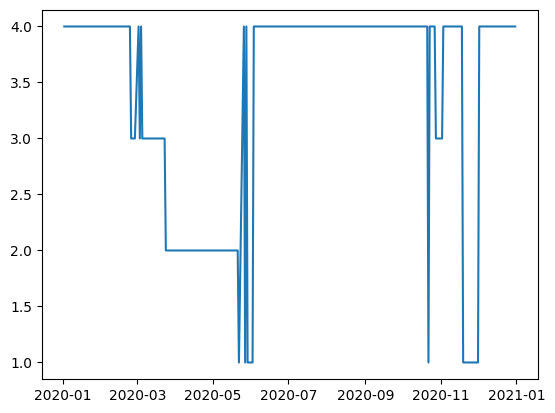

In [22]:
import matplotlib.pyplot as plt
twse_plot = twse[(twse.index >= "2020-01-01") & (twse.index <= "2021-01-01")]
plt.plot(twse_plot['signal'])
plt.show()

In [8]:
def get_performence(date_list,freq='d'):
    etf1_perf = [df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf1[df_etf1.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf2_perf = [df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf2[df_etf2.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf3_perf = [df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf3[df_etf3.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf4_perf = [df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf4[df_etf4.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf5_perf = [df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf5[df_etf5.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf6_perf = [df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf6[df_etf6.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf7_perf = [df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf7[df_etf7.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf8_perf = [df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf8[df_etf8.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    etf9_perf = [df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_ew_return'].mean(),df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_ew_return'].sem(),df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_ew_return'].median(),
                df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_vw_return'].mean(),df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_vw_return'].sem(),df_etf9[df_etf9.index.isin(date_list)][str(freq)+'_vw_return'].median()]
    # print(etf1_perf)
    etf_class_keys = list(etf_list.keys())
    df_perf = pd.DataFrame({
        etf_class_keys[0]: etf1_perf,
        etf_class_keys[1]: etf2_perf,
        etf_class_keys[2]: etf3_perf,
        etf_class_keys[3]: etf4_perf,
        etf_class_keys[4]: etf5_perf,
        etf_class_keys[5]: etf6_perf,
        etf_class_keys[6]: etf7_perf,
        etf_class_keys[7]: etf8_perf,
        etf_class_keys[8]: etf9_perf},index = ['equal_weight_mean','equal_weight_se','equal_weight_median','value_weight_mean','value_weight_se','value_weight_median']).T
    return df_perf

def strategy(df_perf, benchmark='value_weight_mean'):
    buy_etf = df_perf[benchmark].idxmax()
    sell_etf = df_perf[benchmark].idxmin()
    return [buy_etf, sell_etf]

In [13]:
### 用當下過去三年數據算分類
# parameter
year = 3
backtest_period = 250*year
# 多久檢查一次分類(和多久換股一次不一樣)
'''
# by day
iteration = 1

# by week
iteration = 5

# by 4 week
iteration = 20

# by quarter(12 weeks)
iteration = 60
'''
iteration = 1
total = {}
start = "2020-01-01"
end = "2021-01-01"
iter_datetime = twse.index[(twse.index >= start) & (twse.index <= end)]
list_4q = [] # 紀錄每次iteration分類，一樣的話就忽略

for benchmark in ['equal_weight_mean','equal_weight_median','value_weight_mean','value_weight_median']:
    holdings = {} # 紀錄 {datetime: list_4q}，包含 list_4q 所有變動，datetime是分類生效的日期，用datetime的前一個交易日的數據算的

    for i in range(int((len(iter_datetime))/iteration)):
        max_date = iter_datetime[i*iteration]
        min_date = pd.to_datetime(max_date) - timedelta(days=365*3)
        
        q1_dt = [date for date in total_signal_q1 if date < max_date and date >= min_date]
        q2_dt = [date for date in total_signal_q2 if date < max_date and date >= min_date]
        q3_dt = [date for date in total_signal_q3 if date < max_date and date >= min_date]
        q4_dt = [date for date in total_signal_q4 if date < max_date and date >= min_date]
        # print(max_date, min_date)
        # 用過去數據，算 max_date 當天的策略
        etf_q1 = strategy(get_performence(q1_dt,'d'),benchmark=benchmark)
        etf_q2 = strategy(get_performence(q2_dt,'d'),benchmark=benchmark)
        etf_q3 = strategy(get_performence(q3_dt,'d'),benchmark=benchmark)
        etf_q4 = strategy(get_performence(q4_dt,'d'),benchmark=benchmark)
        list_ = [etf_q1,etf_q2, etf_q3, etf_q4]
        len1 = len(q1_dt) 
        len2 = len(q2_dt)
        len3 = len(q3_dt) 
        len4 = len(q4_dt)
        if list_4q != list_:
            list_4q = list_
            print(max_date, list_4q)
        holdings[max_date.strftime("%Y-%m-%d")] = list_4q
    total[benchmark] = holdings
with open(f"Jimmy_rank1_benchmarks_freq_d.json", "w") as f:
    json.dump(total, f, indent=4)

2020-01-02 00:00:00 [['class0', 'class4'], ['class8', 'class5'], ['class8', 'class5'], ['class6', 'class5']]
2020-03-10 00:00:00 [['class0', 'class4'], ['class8', 'class5'], ['class8', 'class5'], ['class4', 'class5']]
2020-03-13 00:00:00 [['class0', 'class4'], ['class8', 'class5'], ['class2', 'class5'], ['class4', 'class5']]
2020-03-25 00:00:00 [['class0', 'class4'], ['class8', 'class2'], ['class2', 'class5'], ['class4', 'class5']]
2020-03-30 00:00:00 [['class0', 'class4'], ['class8', 'class0'], ['class2', 'class5'], ['class4', 'class5']]
2020-04-17 00:00:00 [['class0', 'class4'], ['class8', 'class3'], ['class2', 'class5'], ['class4', 'class5']]
2020-04-20 00:00:00 [['class0', 'class4'], ['class8', 'class0'], ['class2', 'class5'], ['class4', 'class5']]
2020-04-21 00:00:00 [['class0', 'class4'], ['class1', 'class0'], ['class2', 'class5'], ['class4', 'class5']]
2020-04-30 00:00:00 [['class0', 'class4'], ['class1', 'class2'], ['class2', 'class5'], ['class4', 'class5']]
2020-05-01 00:00:00

In [14]:

# ETF1:國內成分證券 ETF
def getNavSeries(df_now_for_nav, weighting, nav_current = 1, short=False):
    if short:
        df2 = (1 - df_now_for_nav.pct_change()).cumprod()
    else:

        df2 = (1 + df_now_for_nav.pct_change()).cumprod()
    # print(df2)
    df3 = df2.fillna(1)
    df4 = df3*nav_current
    nav_series = np.sum(df4 * weighting, axis=1)
    nav = nav_series.iloc[-1]
    return nav_series, nav

def subplots_x_y(total):
    x = np.sqrt(total)
    y = total/x
    if y == np.round(y):
        y = int(y)
    else:
        y = int(y) + 1
    if x == np.round(x):
        x = int(x) + 1
    else:
        x = int(x) + 1
    return x, y

In [15]:
# 回測
with open("Jimmy_rank1_benchmarks_freq_d.json", "r") as f:
    list_strat = json.load(f)
start = pd.to_datetime(list(list_strat[list(list_strat.keys())[0]].keys())[0]) - timedelta(days=1200)
end = pd.to_datetime(list(list_strat[list(list_strat.keys())[0]].keys())[-1])
# start, end
# start = list(list_strat['value_weight_median'].keys())[0]
# end = list(list_strat['value_weight_median'].keys())[-1]
start, end

(Timestamp('2016-09-19 00:00:00'), Timestamp('2020-12-31 00:00:00'))

同ETF pool，不同benckmark

[*********************100%%**********************]  1 of 1 completed


equal_weight_mean {Timestamp('2020-01-02 00:00:00'): [4, 'class6'], Timestamp('2020-03-30 00:00:00'): [2, 'class8'], Timestamp('2020-05-27 00:00:00'): [1, 'class0'], Timestamp('2020-06-24 00:00:00'): [4, 'class7'], Timestamp('2020-12-14 00:00:00'): [4, 'class4']}
equal_weight_median {Timestamp('2020-01-02 00:00:00'): [4, 'class0'], Timestamp('2020-03-30 00:00:00'): [2, 'class8'], Timestamp('2020-05-27 00:00:00'): [1, 'class7'], Timestamp('2020-06-24 00:00:00'): [4, 'class6']}
value_weight_mean {Timestamp('2020-01-02 00:00:00'): [4, 'class6'], Timestamp('2020-03-30 00:00:00'): [2, 'class8'], Timestamp('2020-05-27 00:00:00'): [1, 'class0'], Timestamp('2020-06-24 00:00:00'): [4, 'class7'], Timestamp('2020-12-14 00:00:00'): [4, 'class4']}
value_weight_median {Timestamp('2020-01-02 00:00:00'): [4, 'class0'], Timestamp('2020-03-30 00:00:00'): [2, 'class8'], Timestamp('2020-05-27 00:00:00'): [1, 'class7'], Timestamp('2020-06-24 00:00:00'): [4, 'class6']}


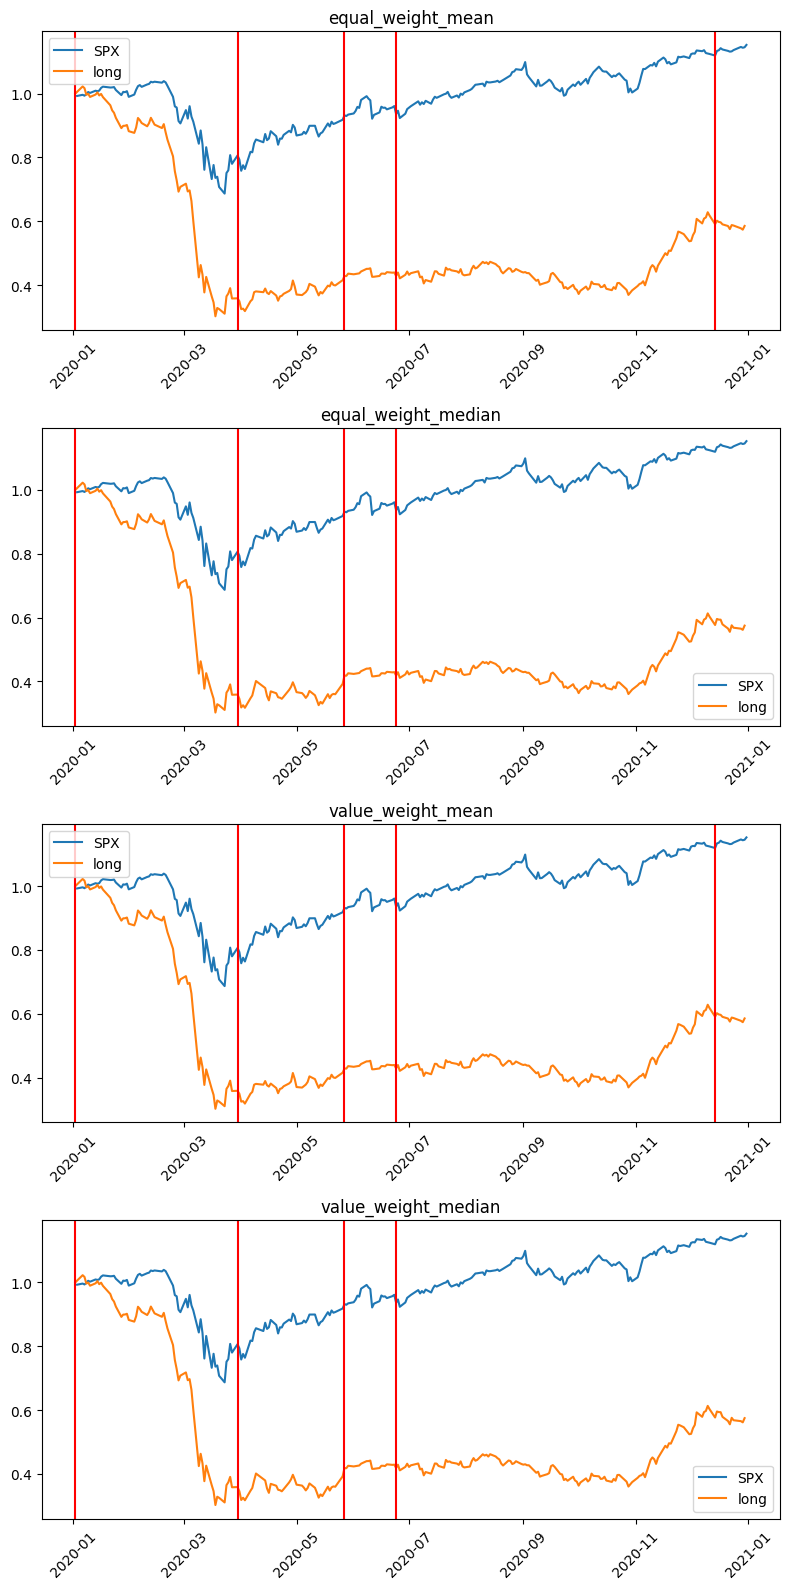

In [25]:
fig, ax = plt.subplots(4, 1, figsize=(8, 16))

# monthly: interval=20
interval = 20
with open("farrell_at2020_top100_cluster9.json", "r") as f:
    data = json.load(f)

etf_list = data

def get_etf_list(etf_list):
    all_etf_list = []
    for etf in etf_list.values():
        all_etf_list.extend(etf)
    return all_etf_list
etfs = get_etf_list(etf_list)

# signal for 2021
df_close = get_data_from_yfinance(etfs, start=start, end=end)


with open("Jimmy_rank1_benchmarks_freq_d.json", "r") as f:
    benchmark_dicts = json.load(f)
benchmarks = list(benchmark_dicts.keys())
spx_close = yf.download("^SPX", start="2020-01-01", end="2021-01-01")['Close']

for benckmark_iter, benchmark in enumerate(benchmarks):

    list_da = []
    graph_iter = 0

    '''
    params init
    '''
    trade_list_buy = {}
    trade_list_sell = {}
    nav_all = pd.Series()
    nav_current = 1

    nav_all_short = pd.Series()
    nav_current_short = 1
    short_current_list = []
    buy_current_list = []
    list_strat = benchmark_dicts[benchmark]

    test_start = list(list_strat.keys())[0]
    test_da = df_close[df_close.index >= test_start].index[::interval]
    start = pd.to_datetime(list(list_strat.keys())[0]) - timedelta(days=1200)
    end = pd.to_datetime(list(list_strat.keys())[-1])
    
    for index, da in enumerate(test_da):
        signal = twse[twse.index == da.strftime("%Y-%m-%d")].signal[0]
        buy_sell = list_strat[da.strftime("%Y-%m-%d")]
        buy_cls = etf_list[buy_sell[signal-1][1]] # buy ETFs
        sell_cls = etf_list[buy_sell[signal-1][0]] # sell ETFs
        # print(signal, da, buy_cls)
        if index == len(test_da) - 1:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
            
            nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
        else:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
            nav_df_short = df _close[sell_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
        nav_df.dropna(axis=1, inplace=True)
        etf_objs = len(nav_df.columns)
        weighting = [1/etf_objs]*etf_objs
        nav_series, nav_current = getNavSeries(nav_df, weighting, nav_current)
        nav_all = pd.concat([nav_all, nav_series], axis=0)

        # nav_df_short.dropna(axis=1, inplace=True)
        # etf_objs_short = len(nav_df_short.columns)
        # weighting_short = [1/etf_objs_short]*etf_objs_short
        # nav_series_short, nav_current_short = getNavSeries(nav_df_short, weighting_short, nav_current_short, short=True)
        # nav_all_short = pd.concat([nav_all_short, nav_series_short], axis=0)
    #     # ========================================
        if buy_current_list != buy_cls:
            
            buy_current_list = buy_cls
            trade_list_buy[da] = [signal, buy_sell[signal-1][0]]
    #     # ========================================

    # =========sell quad
    # nav_all_short = 1/nav_all_short
    # nav_s2 = (nav_all + nav_all_short)/2
    # ax[1].plot(nav_all_short, label='short')
    # ax[0].plot(nav_all_short, label='short')
    # ax[graph_iter].plot(nav_s2, label='strat')
    spx = (1+spx_close.pct_change()).cumprod()
    ax[benckmark_iter].plot(spx, label='SPX')



    ax[benckmark_iter].tick_params(axis='x', rotation=45)
    ax[benckmark_iter].plot(nav_all, label='long')
    ax[benckmark_iter].set_title(benchmark)
    ax[benckmark_iter].legend()
    for i in list(trade_list_buy.keys()):
        ax[benckmark_iter].axvline(i, color="r")
    print(benchmark, trade_list_buy)

plt.tight_layout()

{'Equity': ['VTI', 'IWB', 'SOXX', 'XLI', 'XLY', 'VIOV', 'XLE', 'DIA', 'VOX', 'XLP', 'XLK', 'XLF', 'QQQ', 'VOO'], 'Bond/Fixed Income': ['AGG', 'BND', 'BNDX', 'TLT', 'VCIT'], 'Commodity': ['COMT', 'FTGC', 'DBC', 'GSG', 'DJP'], 'Currency': ['UUP', 'USDU', 'FXY', 'FXE', 'FXC'], 'Specialty-leveraged': ['UDOW', 'SOXL', 'TQQQ', 'TMF', 'UPRO'], 'Specialty-inverse': ['SQQQ', 'SH', 'SDS', 'SOXS', 'SPXU'], 'Factor': ['AVUV', 'AVDV', 'MTUM', 'IMTM', 'QVAL', 'IVAL', 'QMOM', 'IMTM'], 'Other': [], 'Other_2': []}
signal
4    862
1     10
Name: count, dtype: int64


[*********************100%%**********************]  1 of 1 completed


equal_weight_mean {Timestamp('2021-03-16 00:00:00'): [1, 'Factor'], Timestamp('2021-06-04 00:00:00'): [4, 'Equity'], Timestamp('2023-02-03 00:00:00'): [4, 'Commodity'], Timestamp('2023-05-16 00:00:00'): [4, 'Equity'], Timestamp('2023-10-25 00:00:00'): [4, 'Commodity'], Timestamp('2023-12-26 00:00:00'): [4, 'Equity'], Timestamp('2024-02-27 00:00:00'): [4, 'Specialty-leveraged']}
equal_weight_median {Timestamp('2021-03-16 00:00:00'): [1, 'Factor'], Timestamp('2021-05-14 00:00:00'): [4, 'Commodity'], Timestamp('2023-06-06 00:00:00'): [4, 'Equity'], Timestamp('2024-02-06 00:00:00'): [4, 'Specialty-leveraged']}
value_weight_mean {Timestamp('2021-03-16 00:00:00'): [1, 'Factor'], Timestamp('2021-04-06 00:00:00'): [4, 'Equity'], Timestamp('2023-02-03 00:00:00'): [4, 'Commodity'], Timestamp('2023-05-16 00:00:00'): [4, 'Equity'], Timestamp('2023-10-25 00:00:00'): [4, 'Commodity'], Timestamp('2023-12-26 00:00:00'): [4, 'Equity'], Timestamp('2024-03-18 00:00:00'): [4, 'Specialty-leveraged']}
value

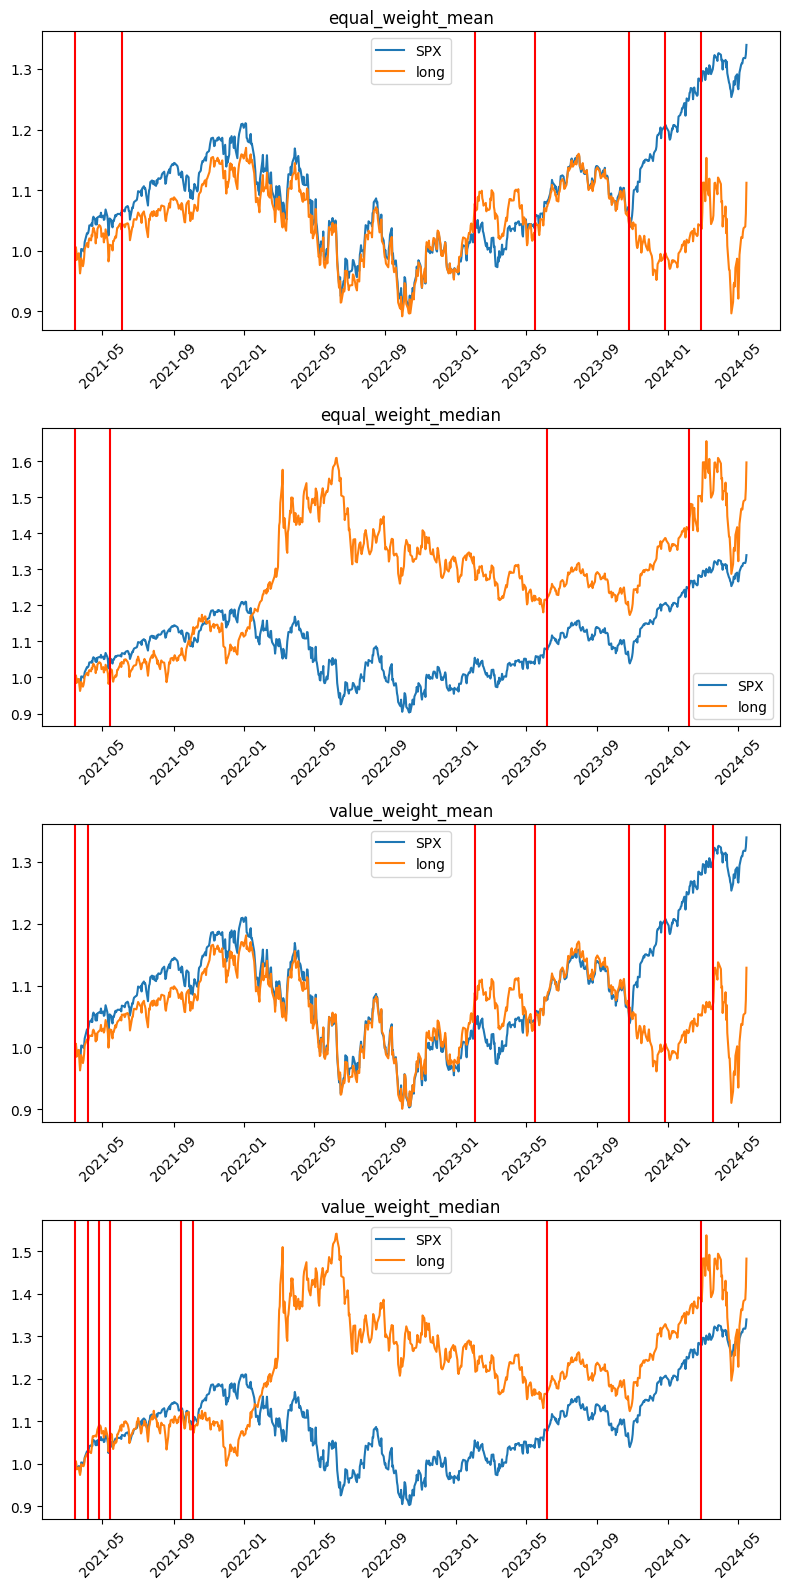

In [209]:
fig, ax = plt.subplots(4, 1, figsize=(8, 16))

# monthly: interval=20
interval = 14

with open("etf_list.json", "r") as f:
    data = json.load(f)
etf_list = data['v4_Antony_Factor2']
print(etf_list)
def get_etf_list(etf_list):
    all_etf_list = []
    for etf in etf_list.values():
        all_etf_list.extend(etf)
    return all_etf_list
etfs = get_etf_list(etf_list)

# signal for 2021
twse = get_quadrants_v2(start=start, end=end)
twse.dropna(inplace=True)
print(twse.signal.value_counts())
df_close = get_data_from_yfinance(etfs, start=start, end=end)


with open("Antony_Factor2_benchmarks_freq_m.json", "r") as f:
    benchmark_dicts = json.load(f)
benchmarks = list(benchmark_dicts.keys())
spx_close = yf.download("^SPX", start="2021-03-16", end=end)['Close']

for benckmark_iter, benchmark in enumerate(benchmarks):

    list_da = []
    graph_iter = 0

    '''
    params init
    '''
    trade_list_buy = {}
    trade_list_sell = {}
    nav_all = pd.Series()
    nav_current = 1

    nav_all_short = pd.Series()
    nav_current_short = 1
    short_current_list = []
    buy_current_list = []
    list_strat = benchmark_dicts[benchmark]

    test_start = list(list_strat.keys())[0]
    test_da = df_close[df_close.index >= test_start].index[::interval]
    start = pd.to_datetime(list(list_strat.keys())[0]) - timedelta(days=1200)
    end = pd.to_datetime(list(list_strat.keys())[-1])
    
    for index, da in enumerate(test_da):
        signal = twse[twse.index == da.strftime("%Y-%m-%d")].signal[0]
        buy_sell = list_strat[da.strftime("%Y-%m-%d")]
        buy_cls = etf_list[buy_sell[signal-1][0]] # buy ETFs
        sell_cls = etf_list[buy_sell[signal-1][1]] # sell ETFs
        # print(signal, da, buy_cls)
        if index == len(test_da) - 1:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
            
            nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
        else:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
            nav_df_short = df_close[sell_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
        nav_df.dropna(axis=1, inplace=True)
        etf_objs = len(nav_df.columns)
        weighting = [1/etf_objs]*etf_objs
        nav_series, nav_current = getNavSeries(nav_df, weighting, nav_current)
        nav_all = pd.concat([nav_all, nav_series], axis=0)

        # nav_df_short.dropna(axis=1, inplace=True)
        # etf_objs_short = len(nav_df_short.columns)
        # weighting_short = [1/etf_objs_short]*etf_objs_short
        # nav_series_short, nav_current_short = getNavSeries(nav_df_short, weighting_short, nav_current_short, short=True)
        # nav_all_short = pd.concat([nav_all_short, nav_series_short], axis=0)
    #     # ========================================
        if buy_current_list != buy_cls:
            
            buy_current_list = buy_cls
            trade_list_buy[da] = [signal, buy_sell[signal-1][0]]
    #     # ========================================

    # =========sell quad
    # nav_all_short = 1/nav_all_short
    # nav_s2 = (nav_all + nav_all_short)/2
    # ax[1].plot(nav_all_short, label='short')
    # ax[0].plot(nav_all_short, label='short')
    # ax[graph_iter].plot(nav_s2, label='strat')
    spx = (1+spx_close.pct_change()).cumprod()
    ax[benckmark_iter].plot(spx, label='SPX')



    ax[benckmark_iter].tick_params(axis='x', rotation=45)
    ax[benckmark_iter].plot(nav_all, label='long')
    ax[benckmark_iter].set_title(benchmark)
    ax[benckmark_iter].legend()
    for i in list(trade_list_buy.keys()):
        ax[benckmark_iter].axvline(i, color="r")
    print(benchmark, trade_list_buy)

plt.tight_layout()

In [ ]:
def plotting(benckmark_iter, )
    list_da = []

    '''
    params init
    '''
    trade_list_buy = {}
    nav_all = pd.Series()
    nav_current = 1

    buy_current_list = []
    list_strat = benchmark_dicts[benchmark]

    test_start = list(list_strat.keys())[0]
    test_da = df_close[df_close.index >= test_start].index[::interval]
    start = pd.to_datetime(list(list_strat.keys())[0]) - timedelta(days=1200)
    end = pd.to_datetime(list(list_strat.keys())[-1])
    
    for index, da in enumerate(test_da):
        signal = twse[twse.index == da.strftime("%Y-%m-%d")].signal[0]
        buy_sell = list_strat[da.strftime("%Y-%m-%d")]
        buy_cls = etf_list[buy_sell[signal-1][0]] # buy ETFs
        # print(signal, da, buy_cls)
        if index == len(test_da) - 1:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= da + timedelta(days=30))]
            
        else:
            nav_df = df_close[buy_cls][(df_close.index >= da) & (df_close.index <= test_da[index+1])]
        nav_df.dropna(axis=1, inplace=True)
        etf_objs = len(nav_df.columns)
        weighting = [1/etf_objs]*etf_objs
        nav_series, nav_current = getNavSeries(nav_df, weighting, nav_current)
        nav_all = pd.concat([nav_all, nav_series], axis=0)

        if buy_current_list != buy_cls:
            
            buy_current_list = buy_cls
            trade_list_buy[da] = [signal, buy_sell[signal-1][0]]
    # ax[graph_iter].plot(nav_s2, label='strat')
    spx = (1+spx_close.pct_change()).cumprod()
    ax[benckmark_iter].plot(spx, label='SPX')



    ax[benckmark_iter].tick_params(axis='x', rotation=45)
    ax[benckmark_iter].plot(nav_all, label='long')
    ax[benckmark_iter].set_title(benchmark)
    ax[benckmark_iter].legend()
    for i in list(trade_list_buy.keys()):
        ax[benckmark_iter].axvline(i, color="r")
    print(benchmark, trade_list_buy)
